## Домашнее задание, вычисление аддитивного аттеншна

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [1]:
from tqdm import tqdm_notebook
from io import open
import unicodedata
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

if torch.cuda.is_available():
    print('CUDA')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
!tail rus_eng_small.txt

она экономически независима от своих родителей .	she is economically independent of her parents .
она направила наши усилия в нужном направлении .	she steered our efforts in the right direction .
на этом заводе производят телевизоры .	they are manufacturing tv sets in this factory .
она всегда жалуется из за моей маленькой зарплаты .	she is always complaining about my small salary .
они стоят там и едят чипсы .	they are standing there and eating potato chips .
мне не удаётся скомпилировать эту программу .	i m having some problems compiling this software .
она улыбнулась в ответ на его нежный взгляд .	she smiled in response to his affectionate glance .
она проводит каждое воскресенье со своей бабушкой .	she spends time with her grandmother every sunday .
каждую субботу после обеда она играет в теннис .	she spends every saturday afternoon playing tennis .
после аварии она перестала бывать на людях .	she stopped appearing in public after her accident .


In [4]:
def readLangs():
    print("Loading dataset...")
    pairs = []
    # Read the file and split into lines
    with open('rus_eng_small.txt') as f:
        for l in tqdm_notebook(f):
            pair = [s for s in l.rstrip('\n').split('\t')]
            pairs.append(pair)

    return Lang('rus'), Lang('eng'), pairs

In [5]:
def prepareData():
    input_lang, output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData()
MAX_LENGTH = 10
print(random.choice(pairs))

Loading dataset...



Read 19288 sentence pairs
Counting words...
Counted words:
rus 8960
eng 3914
['мы не собираемся сегодня ничего покупать .', 'we re not going to buy anything today .']


In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, nlayers, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nlayers)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

## Заполните метод вычисления аддитивного аттеншна в ячейке ниже.

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [8]:
class AttnDecoder(nn.Module):
    """
    Декодер с механизмом внимания dot-product attention
    T1 - шаги входной последовательности
    T2 - шаги выходной последовательности
    """
    def __init__(self, hidden_size, nlayers, output_size):
        """
        :param hidden_size - размер вектора состояния рекуррентного слоя
        :param nlayers - число рекуррентных слоев
        :param output_size - размер словаря выходных текстов
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        # !!! Define layers needed for additive attention here
        self.Wa = nn.Linear(self.hidden_size*2, self.hidden_size, bias=False)
        self.va = nn.Linear(self.hidden_size, 1)
        
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, nlayers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        

    def forward(self, x, hidden, encoder_outputs):
        """
        :param x: [T2,B] - входной тензор с предыдущими словами размерностью timestep на batch
        :param hidden [1, B, C] - состояние рнн слоя
        :param encoder_outputs [T1,B,C] - выходы всех шагов энкодера
        :return output: [T2,B,C], hidden - С=hidden_size, возвращается только последний hidden state
        """
        embedded = self.embedding(x) # [T2,B,C]
        encoder_outputs = encoder_outputs.transpose(0, 1) # [B,T1,C]
        outputs = []
        
        for i in range(x.size(0)):
            h_t = hidden[0].transpose(0, 1).transpose(1, -1) # [B, C, 1]

            context, attn_weights = self.attention(encoder_outputs, h_t)
        
            e = embedded[i].unsqueeze(0)
            output = torch.cat((e, context), dim=-1) # [[B,1,C];[B,1,C]] -> [B,1,C*2]
            output = self.attn_combine(output).transpose(0,1) # [B,1,C*2] * [C*2,C] = [B,1,C] -transpose-> [1,B,C]
            output = F.relu(output)
            output, hidden = self.rnn(output, hidden)

            logits = self.out(output)
            output = F.log_softmax(logits, dim=-1)
            outputs.append(output)
            
        output = torch.cat(outputs, dim=0)
        return output, hidden, attn_weights

    def attention(self, encoder_outputs, h):
        
        text = torch.cat((encoder_outputs,h.permute(0,2,1).repeat(1,encoder_outputs.shape[1],1)),dim=-1)
        
        context = self.va(F.tanh(self.Wa(text)))
        
        attn_weights = F.softmax(context,dim=-2)
        # Для каждой позиции выхода веса содержат значения для всех позиций входа T1
        # В таком случае взвешенная сумма может быть посчитана за одно матричное умножение
        # [B,1,T1]x[B,T1,C] -> B [1,T1]x[T1,C] = [B, 1, C]
        context = torch.bmm(attn_weights.transpose(1,-1), encoder_outputs)
        # на выходе имеем вектор контекста размерностью C для каждой позиции выхода t2
        return context, attn_weights


In [9]:
def train(input_tensor, target_tensor, 
          encoder, decoder, 
          optimizer,  criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    if teacher_forcing_ratio == 1.: # use fast parallel mode
        decoder_input = torch.cat([decoder_input, target_tensor[:-1]], dim=0)
        decoder_outputs, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_outputs = decoder_outputs.squeeze()
        loss += criterion(decoder_outputs, target_tensor.squeeze())
        loss_value = loss.item()
    else:
        for di in range(target_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            loss += criterion(decoder_output, target_tensor[di])
            if use_teacher_forcing:
                decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
        loss_value =  loss.item() / target_length

    loss.backward()

    optimizer.step()

    return loss_value

In [10]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [11]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [12]:
def run_training(encoder, decoder, n_iters, print_every=1000, plot_every=100):
    print('Train')
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            dt = time_since(start, iter / n_iters)
            print('%s (%d %d%%) %.4f' % (dt, iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden # STATE TRANSFER
    
        decoded_words = []
        decoder_attentions = []
        for di in range(max_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            if topi.item() == EOS_token:
                break
            word = output_lang.index2word[topi.item()]
            decoded_words.append(word)

        return decoded_words, decoder_attentions

In [14]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [15]:
n_iters=200000
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in tqdm_notebook(range(n_iters), desc='prepare set')]

In [16]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, 1, hidden_size).to(device)
decoder = AttnDecoder(hidden_size, 1, output_lang.n_words).to(device)

In [17]:
teacher_forcing_ratio = 1.
learning_rate=0.005
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

### Не забудьте запустить тренировку в ячейке ниже, а затем и evaluation

Train


/home/g.varenikov/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0m 2s (- 83m 12s) (100 0%) 4.5672
0m 4s (- 71m 42s) (200 0%) 3.6571
0m 6s (- 66m 41s) (300 0%) 3.6922
0m 7s (- 64m 44s) (400 0%) 3.4858
0m 9s (- 64m 32s) (500 0%) 3.5377
0m 11s (- 64m 15s) (600 0%) 3.5498
0m 13s (- 63m 45s) (700 0%) 3.5037
0m 15s (- 62m 59s) (800 0%) 3.5146
0m 16s (- 61m 48s) (900 0%) 3.5170
0m 18s (- 61m 0s) (1000 0%) 3.7800
0m 20s (- 60m 17s) (1100 0%) 3.9075
0m 21s (- 59m 27s) (1200 0%) 3.5828
0m 23s (- 58m 51s) (1300 0%) 3.8096
0m 24s (- 58m 23s) (1400 0%) 3.7858
0m 26s (- 57m 51s) (1500 0%) 3.7012
0m 27s (- 57m 32s) (1600 0%) 3.7282
0m 29s (- 57m 6s) (1700 0%) 3.4810
0m 30s (- 56m 42s) (1800 0%) 3.6856
0m 32s (- 56m 26s) (1900 0%) 3.8234
0m 34s (- 56m 9s) (2000 1%) 3.5747
0m 35s (- 55m 57s) (2100 1%) 3.7975
0m 38s (- 57m 6s) (2200 1%) 3.8189
0m 40s (- 57m 59s) (2300 1%) 3.6127
0m 42s (- 58m 27s) (2400 1%) 3.6141
0m 45s (- 59m 20s) (2500 1%) 3.7667
0m 47s (- 59m 55s) (2600 1%) 3.5054
0m 49s (- 60m 4s) (2700 1%) 3.4858
0m 50s (- 59m 50s) (2800 1%) 3.6123
0m 52s (- 5

7m 18s (- 56m 46s) (22800 11%) 3.1467
7m 20s (- 56m 44s) (22900 11%) 3.2962
7m 22s (- 56m 41s) (23000 11%) 3.2778
7m 23s (- 56m 39s) (23100 11%) 3.2394
7m 25s (- 56m 35s) (23200 11%) 3.0993
7m 27s (- 56m 33s) (23300 11%) 3.3408
7m 29s (- 56m 31s) (23400 11%) 2.7996
7m 32s (- 56m 35s) (23500 11%) 3.1387
7m 34s (- 56m 38s) (23600 11%) 3.0399
7m 37s (- 56m 39s) (23700 11%) 3.2412
7m 39s (- 56m 39s) (23800 11%) 3.2357
7m 41s (- 56m 41s) (23900 11%) 3.2345
7m 43s (- 56m 39s) (24000 12%) 2.9212
7m 45s (- 56m 38s) (24100 12%) 3.1724
7m 47s (- 56m 38s) (24200 12%) 3.1184
7m 49s (- 56m 36s) (24300 12%) 3.3568
7m 51s (- 56m 36s) (24400 12%) 3.0105
7m 54s (- 56m 40s) (24500 12%) 3.3510
7m 57s (- 56m 44s) (24600 12%) 3.4703
7m 59s (- 56m 46s) (24700 12%) 3.1294
8m 2s (- 56m 48s) (24800 12%) 3.1685
8m 4s (- 56m 46s) (24900 12%) 3.3528
8m 6s (- 56m 42s) (25000 12%) 3.3006
8m 8s (- 56m 42s) (25100 12%) 3.2513
8m 10s (- 56m 44s) (25200 12%) 3.3158
8m 12s (- 56m 42s) (25300 12%) 3.0013
8m 15s (- 56m 45

14m 4s (- 49m 35s) (44200 22%) 3.2441
14m 6s (- 49m 34s) (44300 22%) 3.1486
14m 8s (- 49m 32s) (44400 22%) 3.2688
14m 9s (- 49m 30s) (44500 22%) 2.9605
14m 12s (- 49m 29s) (44600 22%) 3.1398
14m 14s (- 49m 27s) (44700 22%) 2.7818
14m 15s (- 49m 25s) (44800 22%) 3.2184
14m 18s (- 49m 24s) (44900 22%) 3.0104
14m 20s (- 49m 23s) (45000 22%) 3.0848
14m 22s (- 49m 22s) (45100 22%) 3.1952
14m 24s (- 49m 20s) (45200 22%) 3.2502
14m 26s (- 49m 18s) (45300 22%) 3.0206
14m 27s (- 49m 15s) (45400 22%) 3.2032
14m 29s (- 49m 12s) (45500 22%) 2.8657
14m 31s (- 49m 9s) (45600 22%) 3.4098
14m 32s (- 49m 6s) (45700 22%) 2.9507
14m 34s (- 49m 3s) (45800 22%) 2.9955
14m 35s (- 49m 0s) (45900 22%) 2.9558
14m 37s (- 48m 57s) (46000 23%) 3.2221
14m 39s (- 48m 55s) (46100 23%) 3.4152
14m 40s (- 48m 52s) (46200 23%) 3.1392
14m 42s (- 48m 49s) (46300 23%) 3.1942
14m 43s (- 48m 46s) (46400 23%) 2.7344
14m 45s (- 48m 43s) (46500 23%) 2.8174
14m 47s (- 48m 40s) (46600 23%) 2.8951
14m 49s (- 48m 38s) (46700 23%) 3

20m 31s (- 42m 13s) (65400 32%) 3.0375
20m 33s (- 42m 11s) (65500 32%) 3.0964
20m 35s (- 42m 10s) (65600 32%) 2.8875
20m 37s (- 42m 8s) (65700 32%) 3.1473
20m 39s (- 42m 7s) (65800 32%) 3.2449
20m 41s (- 42m 6s) (65900 32%) 2.9230
20m 43s (- 42m 4s) (66000 33%) 2.9677
20m 45s (- 42m 2s) (66100 33%) 3.1642
20m 46s (- 41m 59s) (66200 33%) 3.2042
20m 48s (- 41m 57s) (66300 33%) 3.1067
20m 50s (- 41m 55s) (66400 33%) 3.2358
20m 51s (- 41m 53s) (66500 33%) 3.0990
20m 53s (- 41m 50s) (66600 33%) 2.9942
20m 55s (- 41m 48s) (66700 33%) 3.2679
20m 56s (- 41m 46s) (66800 33%) 2.9683
20m 58s (- 41m 43s) (66900 33%) 2.7650
21m 0s (- 41m 41s) (67000 33%) 3.0222
21m 2s (- 41m 39s) (67100 33%) 3.1833
21m 3s (- 41m 37s) (67200 33%) 2.8050
21m 5s (- 41m 35s) (67300 33%) 2.9703
21m 7s (- 41m 32s) (67400 33%) 3.0732
21m 8s (- 41m 30s) (67500 33%) 3.3158
21m 10s (- 41m 28s) (67600 33%) 3.0780
21m 12s (- 41m 26s) (67700 33%) 3.2322
21m 14s (- 41m 24s) (67800 33%) 3.2713
21m 15s (- 41m 21s) (67900 33%) 3.05

26m 48s (- 35m 6s) (86600 43%) 3.4174
26m 50s (- 35m 4s) (86700 43%) 3.0263
26m 51s (- 35m 1s) (86800 43%) 2.9254
26m 53s (- 35m 0s) (86900 43%) 3.1870
26m 55s (- 34m 58s) (87000 43%) 3.0395
26m 57s (- 34m 56s) (87100 43%) 3.0904
26m 58s (- 34m 54s) (87200 43%) 3.0931
27m 0s (- 34m 51s) (87300 43%) 3.0476
27m 2s (- 34m 49s) (87400 43%) 3.2280
27m 3s (- 34m 47s) (87500 43%) 3.0679
27m 5s (- 34m 45s) (87600 43%) 3.0574
27m 6s (- 34m 43s) (87700 43%) 2.8678
27m 8s (- 34m 41s) (87800 43%) 2.8027
27m 10s (- 34m 39s) (87900 43%) 2.8834
27m 12s (- 34m 37s) (88000 44%) 2.9071
27m 13s (- 34m 35s) (88100 44%) 2.9988
27m 15s (- 34m 33s) (88200 44%) 3.3098
27m 17s (- 34m 31s) (88300 44%) 2.9875
27m 19s (- 34m 29s) (88400 44%) 3.0100
27m 21s (- 34m 27s) (88500 44%) 3.0761
27m 22s (- 34m 25s) (88600 44%) 3.1035
27m 24s (- 34m 23s) (88700 44%) 2.8486
27m 26s (- 34m 21s) (88800 44%) 2.8205
27m 27s (- 34m 19s) (88900 44%) 2.9012
27m 29s (- 34m 17s) (89000 44%) 3.0880
27m 31s (- 34m 15s) (89100 44%) 3.2

34m 0s (- 29m 12s) (107600 53%) 3.1684
34m 1s (- 29m 10s) (107700 53%) 2.8533
34m 3s (- 29m 7s) (107800 53%) 2.9881
34m 5s (- 29m 5s) (107900 53%) 3.3513
34m 6s (- 29m 3s) (108000 54%) 2.9034
34m 8s (- 29m 1s) (108100 54%) 2.8667
34m 9s (- 28m 59s) (108200 54%) 3.0193
34m 11s (- 28m 56s) (108300 54%) 2.9305
34m 12s (- 28m 54s) (108400 54%) 3.1522
34m 14s (- 28m 52s) (108500 54%) 3.0610
34m 15s (- 28m 50s) (108600 54%) 3.1978
34m 17s (- 28m 47s) (108700 54%) 3.0721
34m 18s (- 28m 45s) (108800 54%) 3.1594
34m 20s (- 28m 43s) (108900 54%) 3.0365
34m 21s (- 28m 41s) (109000 54%) 2.9370
34m 23s (- 28m 39s) (109100 54%) 3.1187
34m 24s (- 28m 37s) (109200 54%) 3.0027
34m 26s (- 28m 34s) (109300 54%) 2.7447
34m 28s (- 28m 32s) (109400 54%) 2.9488
34m 29s (- 28m 30s) (109500 54%) 2.8205
34m 31s (- 28m 28s) (109600 54%) 3.2489
34m 32s (- 28m 26s) (109700 54%) 3.2938
34m 34s (- 28m 23s) (109800 54%) 2.9127
34m 35s (- 28m 21s) (109900 54%) 2.8337
34m 37s (- 28m 19s) (110000 55%) 2.8865
34m 38s (- 

40m 9s (- 22m 26s) (128300 64%) 2.7764
40m 11s (- 22m 24s) (128400 64%) 2.8084
40m 13s (- 22m 22s) (128500 64%) 3.0925
40m 15s (- 22m 21s) (128600 64%) 2.9969
40m 17s (- 22m 19s) (128700 64%) 2.7843
40m 19s (- 22m 17s) (128800 64%) 2.9396
40m 21s (- 22m 15s) (128900 64%) 2.7078
40m 23s (- 22m 13s) (129000 64%) 3.1472
40m 25s (- 22m 12s) (129100 64%) 2.6904
40m 27s (- 22m 10s) (129200 64%) 2.9994
40m 29s (- 22m 8s) (129300 64%) 3.1145
40m 30s (- 22m 6s) (129400 64%) 2.9707
40m 32s (- 22m 4s) (129500 64%) 2.8938
40m 35s (- 22m 2s) (129600 64%) 2.6600
40m 36s (- 22m 0s) (129700 64%) 2.6144
40m 39s (- 21m 59s) (129800 64%) 2.7324
40m 40s (- 21m 57s) (129900 64%) 3.1196
40m 42s (- 21m 55s) (130000 65%) 3.0344
40m 43s (- 21m 52s) (130100 65%) 3.2209
40m 45s (- 21m 51s) (130200 65%) 2.8377
40m 47s (- 21m 49s) (130300 65%) 2.4549
40m 49s (- 21m 47s) (130400 65%) 2.8762
40m 50s (- 21m 45s) (130500 65%) 2.9931
40m 52s (- 21m 43s) (130600 65%) 2.9693
40m 54s (- 21m 41s) (130700 65%) 2.7774
40m 56

46m 59s (- 16m 5s) (149000 74%) 3.0128
47m 1s (- 16m 3s) (149100 74%) 2.8903
47m 2s (- 16m 1s) (149200 74%) 2.6979
47m 4s (- 15m 59s) (149300 74%) 2.7987
47m 5s (- 15m 57s) (149400 74%) 2.6758
47m 7s (- 15m 55s) (149500 74%) 2.6787
47m 8s (- 15m 53s) (149600 74%) 2.7959
47m 10s (- 15m 51s) (149700 74%) 2.8920
47m 12s (- 15m 49s) (149800 74%) 3.0611
47m 13s (- 15m 47s) (149900 74%) 2.7148
47m 15s (- 15m 45s) (150000 75%) 2.7636
47m 16s (- 15m 43s) (150100 75%) 3.0450
47m 18s (- 15m 41s) (150200 75%) 3.0659
47m 20s (- 15m 39s) (150300 75%) 2.9669
47m 21s (- 15m 37s) (150400 75%) 2.6180
47m 23s (- 15m 35s) (150500 75%) 2.6881
47m 25s (- 15m 33s) (150600 75%) 2.9082
47m 27s (- 15m 31s) (150700 75%) 2.8570
47m 29s (- 15m 29s) (150800 75%) 2.6728
47m 30s (- 15m 27s) (150900 75%) 3.0717
47m 32s (- 15m 25s) (151000 75%) 2.9812
47m 34s (- 15m 23s) (151100 75%) 3.0344
47m 36s (- 15m 21s) (151200 75%) 2.8339
47m 38s (- 15m 19s) (151300 75%) 3.2101
47m 39s (- 15m 17s) (151400 75%) 2.7549
47m 41s (

53m 18s (- 9m 28s) (169800 84%) 2.9561
53m 21s (- 9m 27s) (169900 84%) 2.8656
53m 23s (- 9m 25s) (170000 85%) 2.5954
53m 25s (- 9m 23s) (170100 85%) 2.8608
53m 27s (- 9m 21s) (170200 85%) 2.7024
53m 30s (- 9m 19s) (170300 85%) 2.6913
53m 32s (- 9m 18s) (170400 85%) 2.9872
53m 35s (- 9m 16s) (170500 85%) 2.6877
53m 37s (- 9m 14s) (170600 85%) 2.6283
53m 39s (- 9m 12s) (170700 85%) 2.9774
53m 41s (- 9m 10s) (170800 85%) 2.7201
53m 43s (- 9m 8s) (170900 85%) 2.8609
53m 44s (- 9m 6s) (171000 85%) 2.7814
53m 46s (- 9m 4s) (171100 85%) 2.9921
53m 48s (- 9m 3s) (171200 85%) 2.9423
53m 49s (- 9m 1s) (171300 85%) 2.8077
53m 51s (- 8m 59s) (171400 85%) 2.7568
53m 52s (- 8m 57s) (171500 85%) 2.7317
53m 54s (- 8m 55s) (171600 85%) 3.1878
53m 56s (- 8m 53s) (171700 85%) 3.0375
53m 58s (- 8m 51s) (171800 85%) 3.0440
54m 0s (- 8m 49s) (171900 85%) 3.2749
54m 2s (- 8m 47s) (172000 86%) 2.7778
54m 3s (- 8m 45s) (172100 86%) 3.1234
54m 5s (- 8m 43s) (172200 86%) 3.1223
54m 7s (- 8m 42s) (172300 86%) 3.0

59m 40s (- 2m 48s) (191000 95%) 2.7398
59m 41s (- 2m 46s) (191100 95%) 2.9621
59m 43s (- 2m 44s) (191200 95%) 2.9186
59m 44s (- 2m 43s) (191300 95%) 2.8725
59m 46s (- 2m 41s) (191400 95%) 2.8164
59m 47s (- 2m 39s) (191500 95%) 3.1332
59m 49s (- 2m 37s) (191600 95%) 2.8325
59m 51s (- 2m 35s) (191700 95%) 2.9470
59m 52s (- 2m 33s) (191800 95%) 3.1048
59m 54s (- 2m 31s) (191900 95%) 2.8613
59m 56s (- 2m 29s) (192000 96%) 3.0050
59m 57s (- 2m 27s) (192100 96%) 2.9758
59m 59s (- 2m 26s) (192200 96%) 2.7796
60m 0s (- 2m 24s) (192300 96%) 2.8388
60m 2s (- 2m 22s) (192400 96%) 2.9633
60m 3s (- 2m 20s) (192500 96%) 2.6506
60m 5s (- 2m 18s) (192600 96%) 2.9425
60m 6s (- 2m 16s) (192700 96%) 2.7784
60m 8s (- 2m 14s) (192800 96%) 2.9052
60m 9s (- 2m 12s) (192900 96%) 2.7875
60m 11s (- 2m 10s) (193000 96%) 2.8546
60m 13s (- 2m 9s) (193100 96%) 2.9335
60m 14s (- 2m 7s) (193200 96%) 2.8110
60m 16s (- 2m 5s) (193300 96%) 2.8673
60m 18s (- 2m 3s) (193400 96%) 2.9224
60m 20s (- 2m 1s) (193500 96%) 2.653

<Figure size 432x288 with 0 Axes>

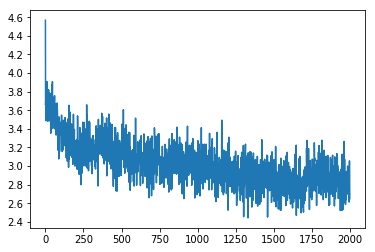

In [18]:
run_training(encoder, decoder, n_iters, print_every=100)

In [19]:
evaluate_randomly(encoder, decoder)

> я рада, что ты мне позвонил .
= i m glad you called me .
< i m glad that that .

> мы встали рано .
= we re up early .
< we re cautious upstairs .

> он низкий, но сильный .
= he is short, but strong .
< he is just a football .

> он лежит на траве .
= he is lying on the grass .
< he is going at sewing .

> я пишу еще один рассказ .
= i m writing another story .
< i m a a tea .

> вы ведь не шпионка, так ?
= you aren t a spy, are you ?
< you re not not spy, ?

> вы посылаете мне японскую куклу, так ?
= you are sending me a japanese doll, right ?
< you re sewing are a a a a spender ?

> это я тебя спас .
= i m the one who saved you .
< i m the going to that .

> я благодарна за то, что ты сделала .
= i m grateful for what you did .
< i m grateful that giving giving that .

> вы мне не помогаете .
= you re not helping me .
< we re not a situation .



input = я очень осторожна .
output = i m very tired of money .


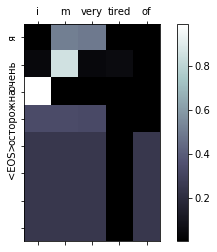

input = они всё ещё живут со своими родителями .
output = i m aware to living friends friends .


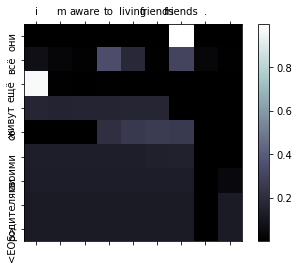

In [20]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_yticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    attentions = torch.cat(attentions).squeeze().cpu()
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("я очень осторожна .")
evaluateAndShowAttention("они всё ещё живут со своими родителями .")